In [58]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error,mean_absolute_percentage_error


from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

# Import SciKit-learn-Inspired Time Series models

from skits.preprocessing import ReversibleImputer
from skits.feature_extraction import (AutoregressiveTransformer, 
                                      SeasonalTransformer)

### Data 

In [59]:
df = pd.read_csv(r"C:\Users\DE737AP\OneDrive - EY\Documents\03. Data Science\GitHub\Machine-Learning-Projects\08. Week 8 Advanced Machine Learning - Time Series Analysis\Energy Demand Forecasting\energy_dataset.csv",
index_col='time', parse_dates=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_offshore_eday_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [60]:
# weather data 
weather = pd.read_csv(r"C:\Users\DE737AP\OneDrive - EY\Documents\03. Data Science\GitHub\Machine-Learning-Projects\08. Week 8 Advanced Machine Learning - Time Series Analysis\Energy Demand Forecasting\weather_features.csv",
index_col='dt_iso', parse_dates=True)
weather.columns = weather.columns.str.lower().str.replace(' ', '_')
# weather.head()

## Getting to Know Our Data

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal/lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-null  float64
 9   generation_hydro_pumped_storage_a

In [62]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
# df_features = ['temp','pressure','humidity','wind_speed','rain_1h','snow_3h','clouds_all','total_load_actual']
df.columns


Index(['generation_biomass', 'generation_fossil_brown_coal/lignite',
       'generation_fossil_coal-derived_gas', 'generation_fossil_gas',
       'generation_fossil_hard_coal', 'generation_fossil_oil',
       'generation_fossil_oil_shale', 'generation_fossil_peat',
       'generation_geothermal', 'generation_hydro_pumped_storage_aggregated',
       'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_marine',
       'generation_nuclear', 'generation_other', 'generation_other_renewable',
       'generation_solar', 'generation_waste', 'generation_wind_offshore',
       'generation_wind_onshore', 'forecast_solar_day_ahead',
       'forecast_wind_offshore_eday_ahead', 'forecast_wind_onshore_day_ahead',
       'total_load_forecast', 'total_load_actual', 'price_day_ahead',
       'price_actual'],
      dtype='object')

## Feature Engineering

## Time Series Analysis

## Univariate versus multivariate time series models

In time series data, timestamps hold intrinsic meaning. Univariate time series models use only one variable (the target variable) and its variation over time to make future predictions.

In contrast, multivariate time series models include additional variables. For instance, if you want to forecast product demand, you might consider including weather data as an influencing factor. Multivariate models extend univariate models by integrating these additional (or external) variables

In [63]:
# a simple time series DF for use in models without the exogenous variables
df_endog = pd.DataFrame(df['total_load_actual'])
df_endog.tail()

,total_load_actual
time,
2018-12-31 19:00:00+01:00,30653.0
2018-12-31 20:00:00+01:00,29735.0
2018-12-31 21:00:00+01:00,28071.0
2018-12-31 22:00:00+01:00,25801.0
2018-12-31 23:00:00+01:00,24455.0


In [64]:
df_endog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_load_actual  35028 non-null  float64
dtypes: float64(1)
memory usage: 547.9+ KB


In [65]:
df_endog.fillna(method='ffill',inplace=True)

C:\Users\DE737AP\AppData\Local\Temp\ipykernel_38408\1700603386.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_endog.fillna(method='ffill',inplace=True)


<Axes: xlabel='time'>

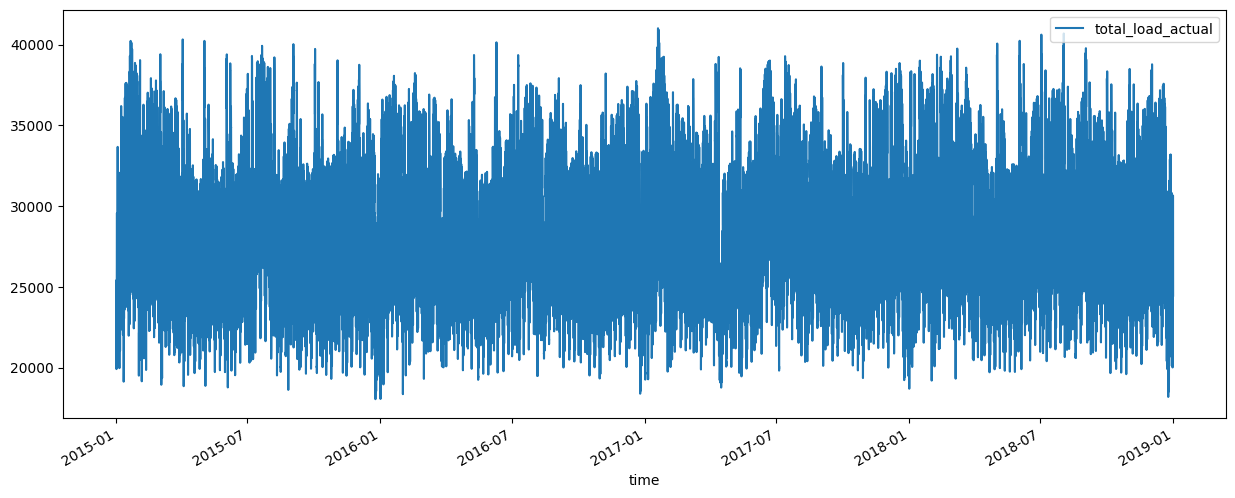

In [66]:
df_endog.plot(figsize=(15, 6))

### Test for Stationarity

With the univariate TS dataframe, I will use the statsmodels Augmented Dickey-Fuller test to test for stationarity. The null hypothesis is that the series is not stationary (no trend, constant variance over time, constant autocorrelation structure over time) and the alternative hypothesis is that the time series is stationary. If the p-value is less than 0.05, we reject the null hypothesis and conclude the series is stationary. 

In [67]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [68]:
adf_test(df_endog['total_load_actual'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -21.441581
p-value                     0.000000
# lags used                52.000000
# observations          35011.000000
critical value (1%)        -3.430537
critical value (5%)        -2.861623
critical value (10%)       -2.566814
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


With a p-value of zero, we can say that the data are stationary. Even though we know the data have seasonality, perhaps the p-value is so low because there is very little trend. But let's have a look at the decomposition of the trend, seasonality, and residuals. Let's start with the largest seasonal component, the yearly seasonality:

### Decompose the T/S

Time series decomposition

You can decompose the time series to extract different types of variation from your dataset. This will extract three key features from your data:

Seasonality is a recurring pattern based on time periods (such as seasons of the year). For example, temperatures typically rise in the summer and fall in the winter. You can use this predictable pattern to help predict future values.
Trends reflect long-term increases or decreases in your data. Going back to our temperature example, you could observe a gradual upward trend due to global warming, layered on top of seasonal variations.
Noise is random variability that doesn’t follow seasonality or trend. It represents unpredictable fluctuations in the data, meaning no model can fully account for it (that’s why it’s also often called the “error” or “residual” in the data).

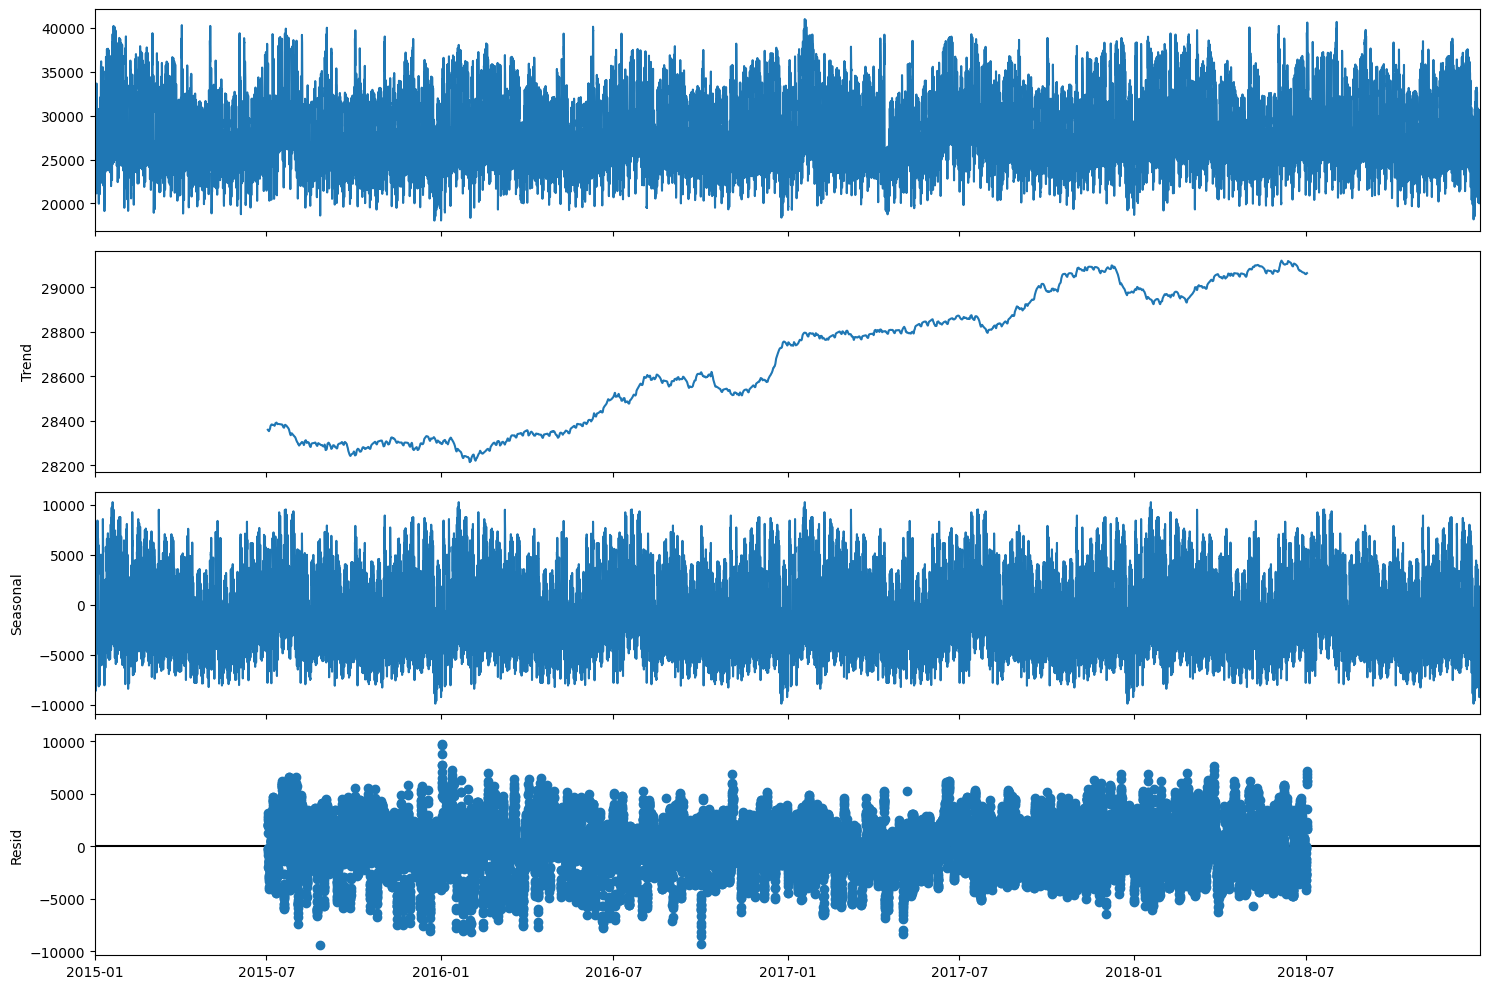

In [69]:
#seasonal decomposition
import statsmodels.api as sm
# Set the figure size
plt.rcParams['figure.figsize'] = [15, 10]

decomp = sm.tsa.seasonal_decompose(df_endog, period=24*365) #the yearly seasonal component
decomp.plot(); #plot the seasonal components #use the ; to avoid multiple plots 

So the seasonal decomposition actually does show a trend, but it is so small as to almost be negligible (an increase of about 900 MWH out of about 30000 over 4 years). The seasonal component plot clearly shows the peaks during summer and winter and relative lows in spring and fall.

C:\Users\DE737AP\AppData\Local\Temp\ipykernel_38408\496752193.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_daily = df_endog.resample('M').mean()


<Axes: xlabel='time'>

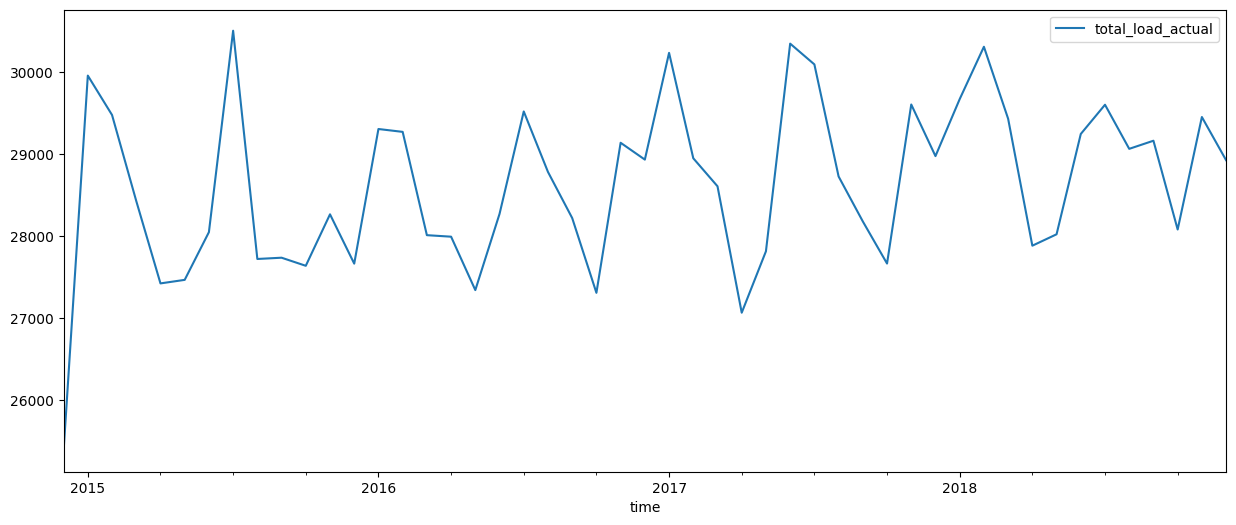

In [70]:
## Try Resampling the data to Monthly
## convert the index to datetime
df_endog.index = pd.to_datetime(df_endog.index,utc=True)
df_daily = df_endog.resample('M').mean()
df_daily.plot(figsize=(15, 6))


## Classical time series models
These traditional models, such as ARIMA and Exponential Smoothing, are based on time-based patterns in a time series. While highly effective for forecasting single-variable (univariate) series, some advanced options exist to add external variables as well. 

Classical models like these are specific to time series data and generally aren’t suitable for other types of machine learning.

In [71]:
# Define the size of the training data
train_size = int(len(df_endog) * 0.8)
train, test = df_endog[:train_size], df_endog[train_size:]

In [72]:
# from pmdarima import auto_arima

# # Auto ARIMA for parameter tuning
# auto_model = auto_arima(train['total_load_actual'], seasonal=False, trace=True,
#                          error_action='ignore', suppress_warnings=True,
#                          stepwise=True)
# print("ARIMA Model Summary:")
# print(auto_model.summary())

In [73]:
from statsmodels.tsa.arima.model import ARIMA

In [74]:
# Fit the ARIMA model with the best parameters from auto_arima
train = train.asfreq('h') # make sure the data is hourly
arima_model =ARIMA(train, order=(1,0,1))
arima_fit = arima_model.fit()

# transform test set 
test.index = pd.to_datetime(test.index,utc=True)
test = test.asfreq('h')

# Forecast with ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))

In [75]:
# Calculate Mean Squared Error for ARIMA
arima_mse = root_mean_squared_error(test['total_load_actual'], arima_forecast)
print(f'ARIMA Mean Squared Error: {arima_mse:.2f}')

# Calculate Mean Absolute Percentage Error for ARIMA
arima_mape = mean_absolute_percentage_error(test['total_load_actual'], arima_forecast)

print(f'ARIMA Mean Absolute Percentage Error: {arima_mape:.2f}')

ARIMA Mean Squared Error: 4521.27
ARIMA Mean Absolute Percentage Error: 0.14


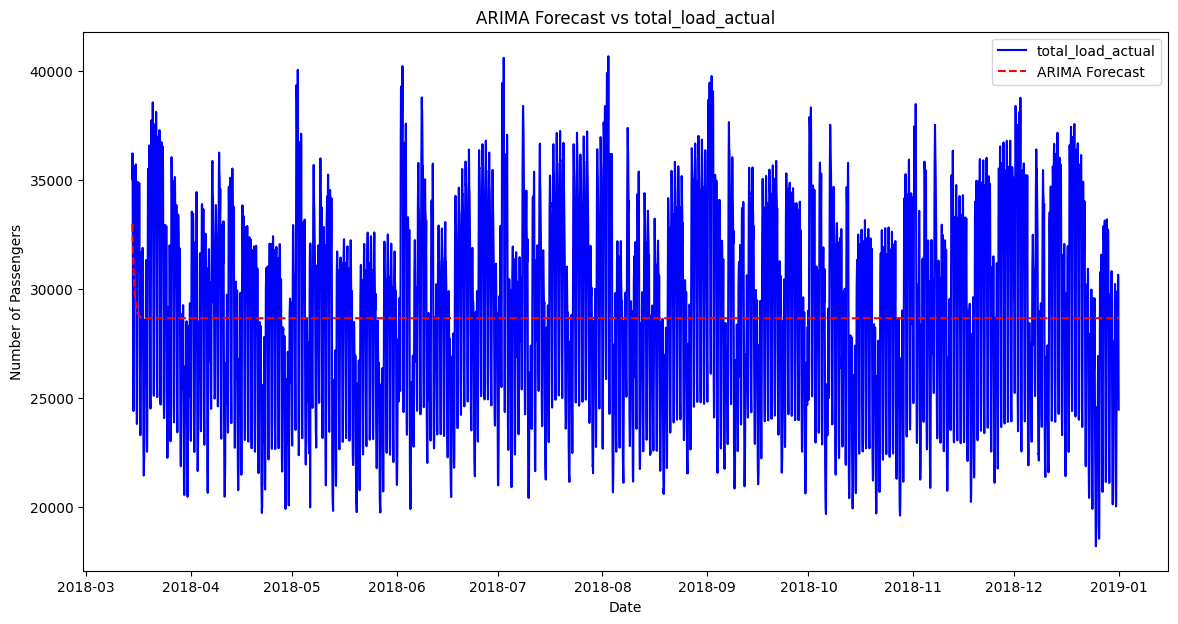

In [76]:
# Plot forecasts
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['total_load_actual'], label='total_load_actual', color='blue')
plt.plot(test.index, arima_forecast, color='red', linestyle='--', label='ARIMA Forecast')
plt.title('ARIMA Forecast vs total_load_actual')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## ACF PACF PLOTS 
I will try plotting the auto and partial autocorrelations to try to determine the q (moving average- MA) and p (auto regression -AR) terms of the ARIMA model. The daily trend should be readily apparent in the ACF plot:

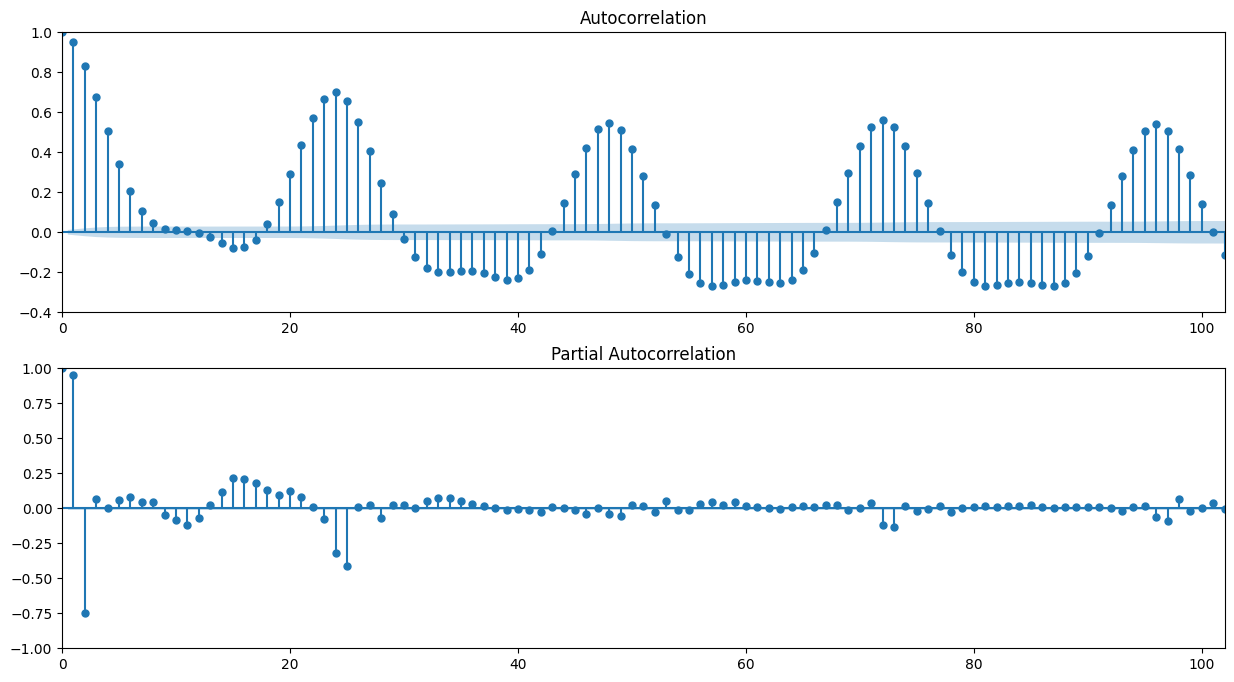

In [77]:
%%capture --no-display
#plot ACF and PACF
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(train, lags=240, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=240, ax=ax[1])
ax[0].set_xlim(0, 102)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(0, 102)
plt.show()

In [78]:
# Next I will apply first and 24-hour seasonal differences to see how they affect the stationarity of the data:
ytrain_seas = train.diff(24)
ytrain_diff = train.diff()
ytrain_both = train.diff()
ytrain_both.tail()

,total_load_actual
time,
2018-03-14 13:00:00+00:00,-1197.0
2018-03-14 14:00:00+00:00,-594.0
2018-03-14 15:00:00+00:00,-520.0
2018-03-14 16:00:00+00:00,-131.0
2018-03-14 17:00:00+00:00,181.0


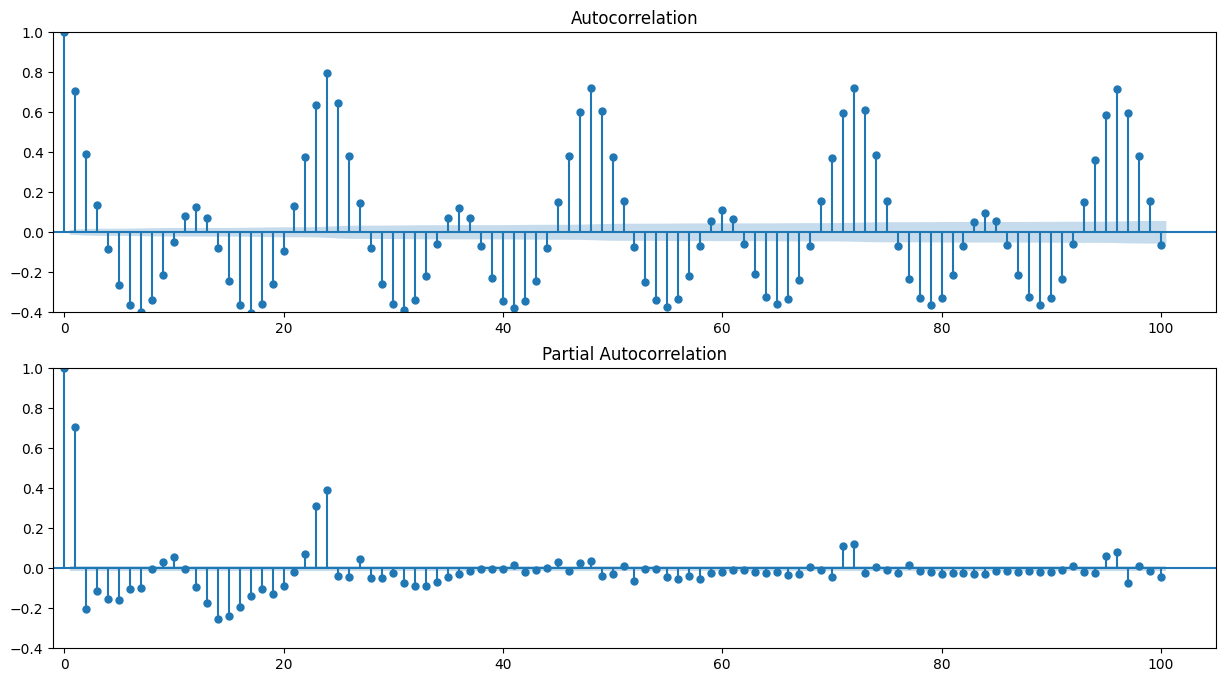

In [79]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(ytrain_both[25:], lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ytrain_both[25:], lags=100, ax=ax[1])
ax[0].set_xlim(-1, 105)
ax[0].set_ylim(-0.4,1)
ax[1].set_xlim(-1, 105)
ax[1].set_ylim(-0.4,1)
plt.show()

After differencing and seasonal differencing, the ACF and PACF plots still do not give much indication of which terms would be good for the AR and MA terms of the model.
So given the above information, a first pass at SARIMA parameters might be: (1,0,1)x(1,0,1,24) since d=0 for no trend.

SARIMA Model Fitting

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sar_mod = sm.tsa.statespace.SARIMAX(train, order=(1,0,1),
                                     seasonal_order=(1,1,1,24*7), freq='h')

In [81]:
sar_res = sar_mod.fit(method = 'powell')
# sar_res.summary()

KeyboardInterrupt: 

In [ ]:
# Forecast with SARIMA
sarima_forecast = sar_res.get_forecast(steps=len(test))
sarima_mse = root_mean_squared_error(test['total_load_actual'], sarima_forecast.predicted_mean) 
sarima_mape = mean_absolute_percentage_error(test['total_load_actual'], sarima_forecast.predicted_mean)

# Print the Mean Squared Error for SARIMA
print(f'SARIMA Mean Squared Error: {sarima_mse:.2f}')
print(f'SARIMA Mean Absolute Percentage Error: {sarima_mape:.2f}')

SARIMA Mean Squared Error: 15756.55
SARIMA Mean Absolute Percentage Error: 0.53


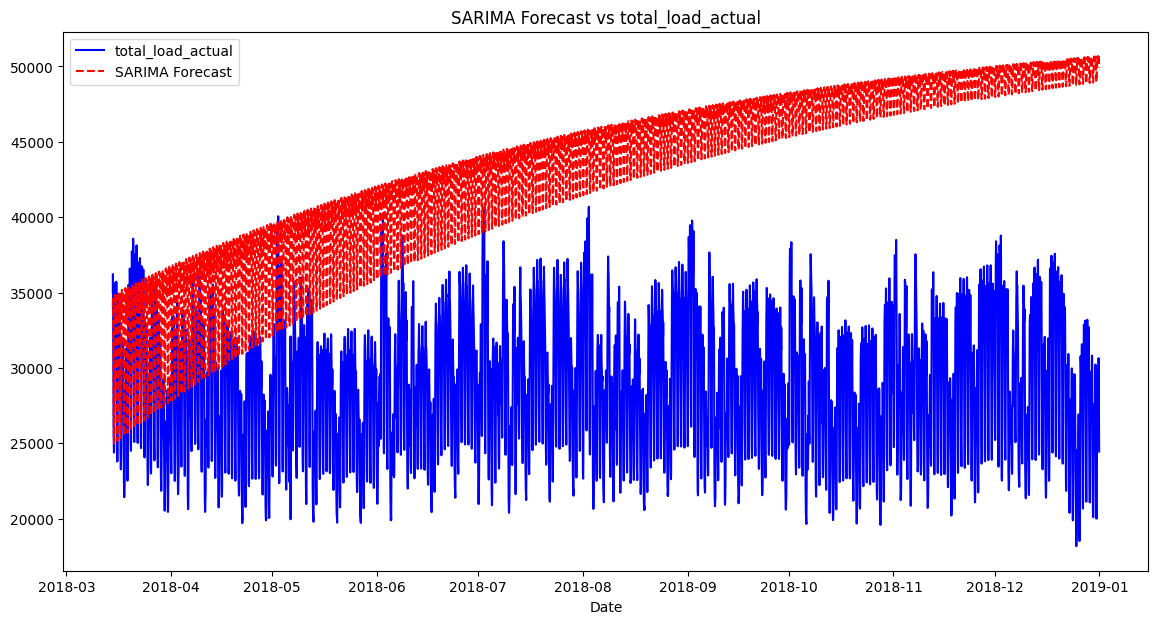

In [ ]:
# Plot the Forecasts for SARIMA
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['total_load_actual'], label='total_load_actual', color='blue')
plt.plot(test.index, sarima_forecast.predicted_mean, color='red', linestyle='--', label='SARIMA Forecast')
plt.title('SARIMA Forecast vs total_load_actual')
plt.xlabel('Date')
plt.legend()
plt.show()


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2181      0.011     19.155      0.000       0.196       0.240
ma.L1          0.1210      0.011     10.791      0.000       0.099       0.143
ar.S.L24      -0.3327      0.002   -220.174      0.000      -0.336      -0.330
sigma2      6.736e+05   1589.043    423.910      0.000     6.7e+05    6.77e+05


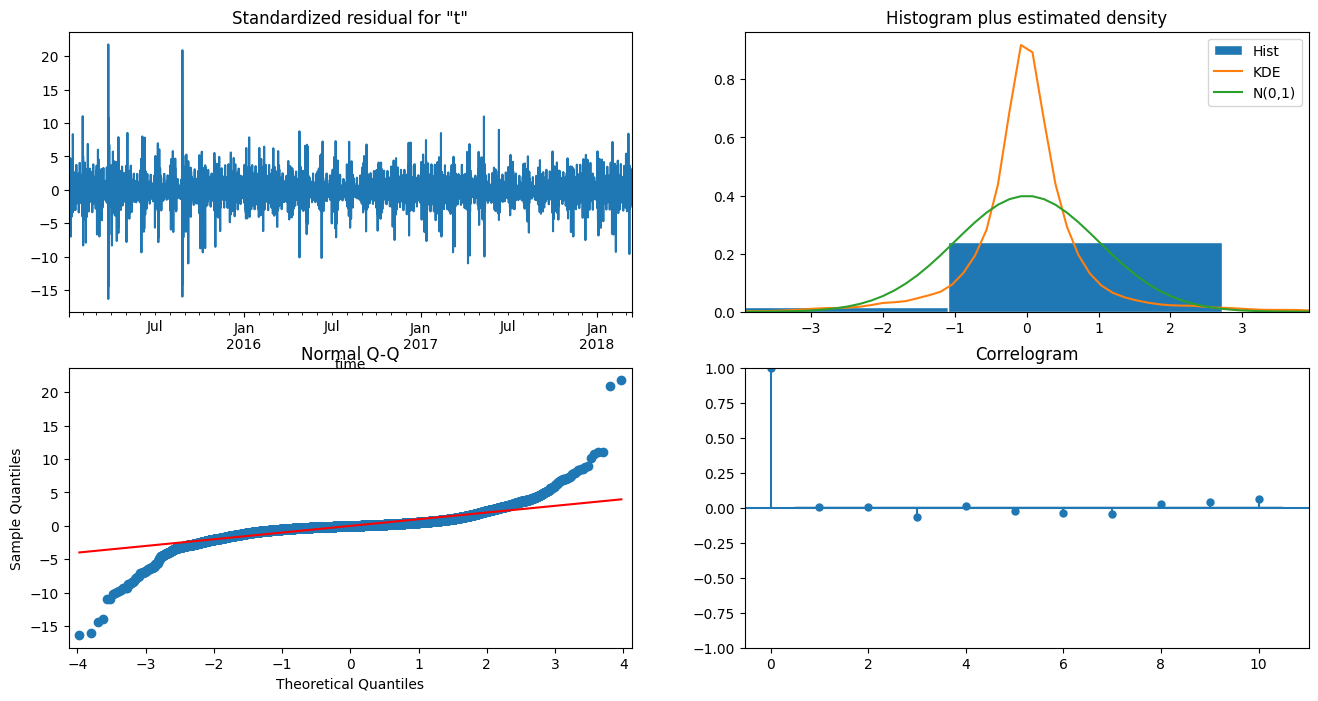

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Conclusion 
1. ARIMA: Classical model for univariate time series data, including parameter tuning and evaluation.
2. SARIMA: Extension of ARIMA to handle seasonality, with tuning and evaluation steps.